<a href="https://colab.research.google.com/github/ecampos14/Automacao/blob/main/Mineda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Pandas
import pandas as pd

# Configuração do matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Sklearn e Skforecast
from sklearn.ensemble import RandomForestRegressor

!pip install skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 560.6/560.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.1 MB/s eta 0:00:00


# Nova seção

In [2]:
url = '/content/Electric_Production.csv'
data = pd.read_csv(url)
print(data.head(5))

         DATE    Value
0  01-01-1985  72.5052
1  02-01-1985  70.6720
2  03-01-1985  62.4502
3  04-01-1985  57.4714
4  05-01-1985  55.3151


In [3]:
#Renomeando colunas
data = data.rename(columns={'Value': 'value'})
data = data.rename(columns={'DATE': 'date'})
print(data.head(2))

         date    value
0  01-01-1985  72.5052
1  02-01-1985  70.6720


In [4]:
# Converta a coluna 'date' para o formato datetime
data['date'] = pd.to_datetime(data['date'])
# Remove a parte do horário da coluna 'date'
data['date'] = data['date'].dt.date
data = data.sort_index()
print(data.head(30))

          date    value
0   1985-01-01  72.5052
1   1985-02-01  70.6720
2   1985-03-01  62.4502
3   1985-04-01  57.4714
4   1985-05-01  55.3151
5   1985-06-01  58.0904
6   1985-07-01  62.6202
7   1985-08-01  63.2485
8   1985-09-01  60.5846
9   1985-10-01  56.3154
10  1985-11-01  58.0005
11  1985-12-01  68.7145
12  1986-01-01  73.3057
13  1986-02-01  67.9869
14  1986-03-01  62.2221
15  1986-04-01  57.0329
16  1986-05-01  55.8137
17  1986-06-01  59.9005
18  1986-07-01  65.7655
19  1986-08-01  64.4816
20  1986-09-01  61.0005
21  1986-10-01  57.5322
22  1986-11-01  59.3417
23  1986-12-01  68.1354
24  1987-01-01  73.8152
25  1987-02-01  70.0620
26  1987-03-01  65.6100
27  1987-04-01  60.1586
28  1987-05-01  58.8734
29  1987-06-01  63.8918


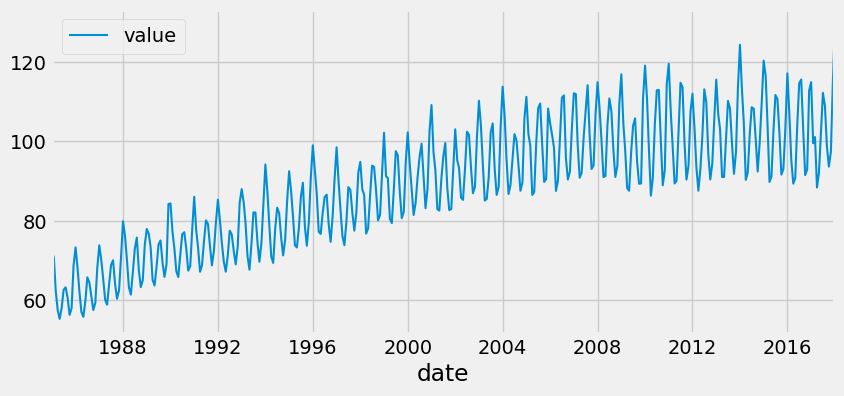

In [5]:
# Define os limites do eixo x manualmente
left_limit = '1985-01-01'
right_limit = '01-01-2018'

# Cria uma figura e eixos
fig, ax = plt.subplots(figsize=(9, 4))

# Plota os dados da coluna 'value'
data.plot(x='date', y='value', ax=ax, label='value')

# Adiciona legenda
ax.legend()

# Define os limites do eixo x
ax.set_xlim(left_limit, right_limit)

# Exibe o gráfico
plt.show()


In [12]:
print(f'Número de linhas com valores ausentes: {data.isnull().any(axis=1).mean()}')

Número de linhas com valores ausentes: 0.0


In [6]:
# Verifica se não existem valores NaN nos dados
no_missing_values = data['value'].isna().sum() == 0

# Verifica se não existem datas duplicadas
no_duplicates = len(data.index.unique()) == len(data.index)

# Verifica se o índice está em ordem cronológica
in_chronological_order = (data.index == data.sort_index().index).all()

# Se não houver valores ausentes, datas duplicadas e o índice estiver em ordem cronológica, não há "buracos" nos dados
no_missing_values and no_duplicates and in_chronological_order


True

In [7]:
# Verifica se não existem datas faltantes
expected_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='MS')
no_missing_dates = set(expected_dates).issubset(data.index)

# Se todas as datas esperadas estiverem presentes no índice do DataFrame, não há "buracos" nos dados
no_missing_dates

False

Datas de Treinamento : 0 --- 330  (n=331)
Datas de Teste  : 331 --- 396  (n=66)


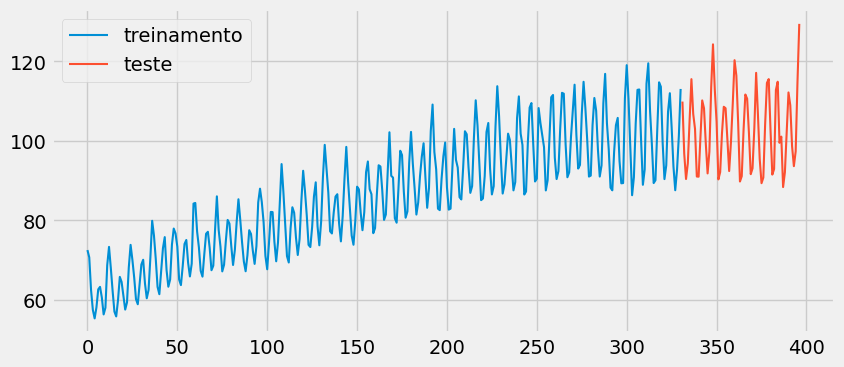

In [8]:
# Divide os dados em treinamento e teste
# Para séries temporais, sempre utilizamos os dados mais recentes para teste
steps = 66  # Número de dias para teste
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Datas de Treinamento : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Datas de Teste  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Plotando os dados
fig, ax=plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='treinamento')
data_test['value'].plot(ax=ax, label='teste')
ax.legend();


# Nova seção

In [9]:
# Configura e treina um RandomForestRegressor para série temporal
# Os parâmetros foram retirados do melhor modelo encontrado no material de origem
# Para conseguir os melhores parâmetros, é necessário realizar ajuste de hiperparâmetros (verifique o artigo original)
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=123),
                lags      = 12
             )

In [10]:
forecaster.fit(y=data_train['value'])

# Faz a previsão no conjunto de teste
predictions = forecaster.predict(steps=steps)
predictions.head(5)

331    109.780313
332     98.326113
333     90.090324
334     93.702336
335    107.175752
Name: pred, dtype: float64

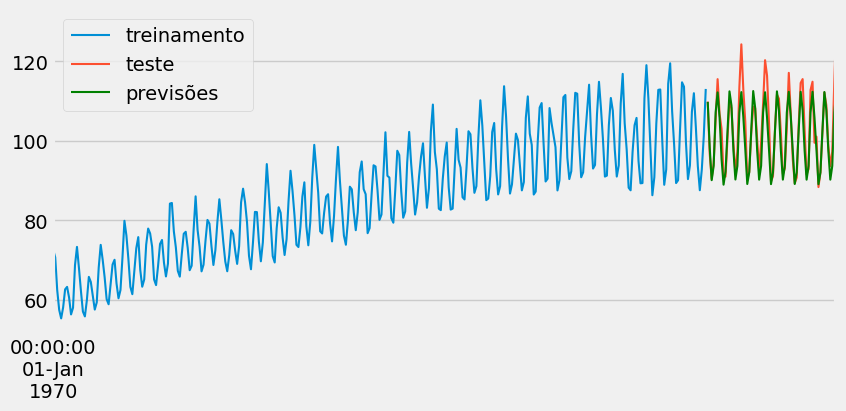

In [11]:
# Convertendo os índices para datetime
data_train.index = pd.to_datetime(data_train.index)
data_test.index = pd.to_datetime(data_test.index)
predictions.index = pd.to_datetime(predictions.index)

# Plota a predição, comparando com valores reais
fig, ax=plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='treinamento')
data_test['value'].plot(ax=ax, label='teste')
predictions.plot(ax=ax, label='previsões', color='green')
ax.legend();
